In [6]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


#利用pandas 讀取csv檔
import pandas as pd
df=pd.read_csv('~/Desktop/train.csv')
#df=pd.read_csv('~/Desktop/bias_paper_train.csv')
#df=pd.read_csv('~/Desktop/outgroup_paper_train.csv')

data=df.values

import random
#將資料打亂
#random.shuffle(data)
np.random.shuffle(data)

'''
X=data[:,[2,3,4,5,6,7]]
y=data[:,1]
'''


#X=data[:,[49,53,54,56,58,61]]
#print(X[:10])
#X=data[:,[49,53,54,56,58,61,62,63,64]]
X=data[:,[49,50,51,52,54,56,58,61,62,63,64]]
y=data[:,46]
#y=data[:,47]


'''
#增加二次項訓練資料給XGBoost
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly=poly.fit_transform(X)
print(X_poly.shape)

X=X_poly
'''
i=1
data_num=1340
X_train=np.delete(X, slice(data_num*i,data_num*(i+1)), axis=0)
X_test=X[data_num*i:data_num*(i+1)]
y_train=np.delete(y, slice(data_num*i,data_num*(i+1)), axis=0)
y_test=y[data_num*i:data_num*(i+1)]

print(X_train.shape)
print(X_test.shape)

(1340, 11)
(670, 11)


In [7]:
import xgboost as xgb
from xgboost import plot_tree

#booster='dart', eval_metric='rmse', n_estimators=3, max_depth=20, gamma=0.1
params = {
    'booster':'dart', #dart, gbtree 
    'eval_metric':'rmse',
    #'objective':'reg:squarederror',
    #'alpha': 0.1,  # L1正則化參數
    #'lambda': 0.1,  # L2正則化參數
    'gamma':0.1,
    'eta':0.75,  # 學習率
    'max_depth': 5,  # 樹的最大深度
    #'min_child_weight': 1,  # 葉節點上的最小權重
    #'subsample': 0.8,  #每棵樹的樣本比例
    #'colsample_bytree': 0.8,  #每棵樹的特徵比例
    'n_estimators': 20,  #樹的數量
    'seed': 4  #隨機種子
}
# 建立 XGBRegressor 模型
xgboostModel=xgb.XGBRegressor(**params)
# 使用訓練資料訓練模型
xgboostModel.fit(X_train,y_train)
# 使用訓練資料預測
#predicted=xgbrModel.predict(x)

print('Train:', xgboostModel.score(X_train, y_train))
print('Test:', xgboostModel.score(X_test, y_test))

Train: 0.9440483659831524
Test: 0.49608892777729496


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


y_pred = xgboostModel.predict(X_train)
# 计算均方根误差
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE:", rmse)

y_pred = xgboostModel.predict(X_test)
# 计算均方根误差
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.3292704019136816
RMSE: 0.9567316721481748


[0.09339    0.1397962  0.07121286 0.02940567 0.13539621 0.05871303
 0.0333722  0.3447227  0.02799261 0.03129074 0.03470778]


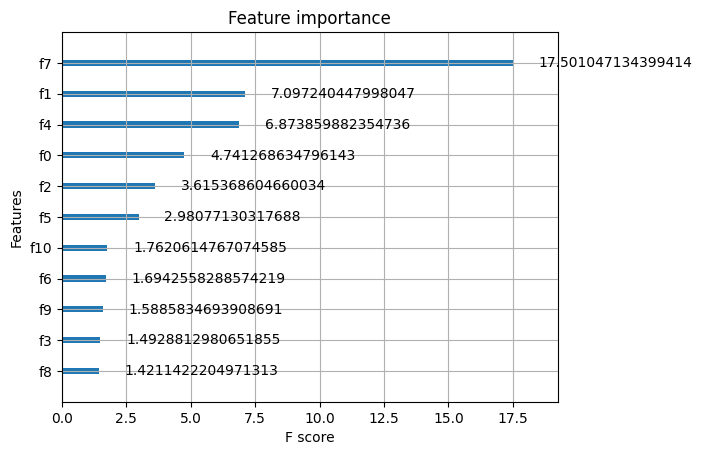

In [9]:
# 可視化特徵的重要性
xgb.plot_importance(xgboostModel, importance_type='gain')

# 獲取特徵的重要性分數
importance_scores = xgboostModel.feature_importances_
print(importance_scores)

#0: symbolic 49
#1 sol:50
#2 sat:51
#3 cen:52
#4 contact_quality:54
#5 contact_friendsz: 56
#6 genralized 61
#7 disgust_s  63
#8 disgust_r  64

#[49,53,54,56,58,61,62,63,64]


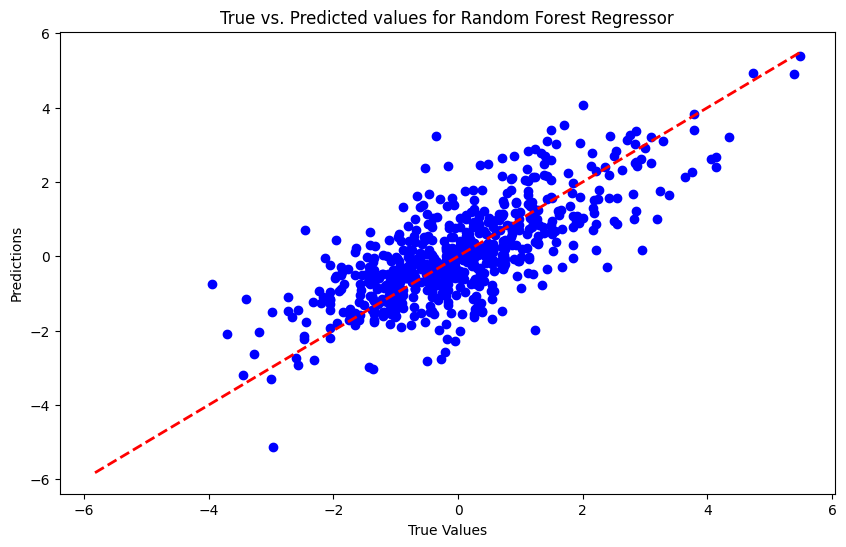

In [10]:
import matplotlib.pyplot as plt

y_pred = xgboostModel.predict(X_test)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle='--', color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted values for Random Forest Regressor')
plt.show()